In [1]:
from calibrate.cluster_model import ClusterFactory, ClusteringOptimizer
from calibrate.cointegration import CointegrrationTest, BasketCointegrationTest
from calibrate.OU_calibration import OUCalibration
from calibrate.baskets import Basket
from metric_calculation.backtest import BackTest
from utils.price_data_utils import get_time_series
from strategy.simple_implementation import OUTrader
import matplotlib.pyplot as plt
%matplotlib inline

# Fill these cells after running the data parsing script
sector = "Information Technology"
data_start_date = 20100101
data_end_date = 20170101

backtest_start_date = 20180101
backtest_end_date = 20250915
initial_capital = 100000

In [2]:
start_date = data_start_date
end_date = data_end_date
results = {}
for method in ["kmeans", "gmm", "hierarchical", "spectral"]:
    print(f"\n--- Testing {method.upper()} ---")
    model = ClusterFactory.create(method, sector, start_date, end_date)
    optimizer = ClusteringOptimizer(model)
    best_params, best_score, all_results = optimizer.search()
    print(f"Best_parameters: {best_params}")
    print(f"custom score: {best_score}")
    results[method] = (best_params, best_score)


--- Testing KMEANS ---
Best_parameters: {'n_clusters': 10}
custom score: 0.8903151363655653

--- Testing GMM ---
Best_parameters: {'n_components': 10, 'covariance_type': 'full'}
custom score: 0.9957682241937804

--- Testing HIERARCHICAL ---
Best_parameters: {'n_clusters': 9, 'linkage': 'average'}
custom score: 0.8989953733213722

--- Testing SPECTRAL ---
Best_parameters: {'n_clusters': 10, 'affinity': 'nearest_neighbors'}
custom score: 0.6654449149537476


In [3]:
# Best parameters and clustering method
best_method, (best_params, best_score) = max(results.items(), key=lambda x: x[1][1])
print(f"\nBest method: {best_method.upper()} with score {best_score}")

# Getting Clustered Data
model = ClusterFactory.create(best_method, sector, start_date, end_date, **best_params)
model.fit()
model.show_baskets()
model.evaluate()
clustered_data = model.get_clustered_data()


Best method: GMM with score 0.9957682241937804

Cluster 0 (7 items):
['AKAM', 'AMAT', 'AVGO', 'EA', 'JNPR', 'LRCX', 'CRM']

Cluster 1 (14 items):
['ACN', 'GOOGL', 'GOOG', 'APH', 'ANSS', 'CSCO', 'IT', 'GPN', 'IBM', 'MCHP', 'MSFT', 'QCOM', 'TEL', 'VRSN']

Cluster 2 (2 items):
['AAPL', 'NVDA']

Cluster 3 (2 items):
['AMD', 'MU']

Cluster 4 (5 items):
['ADSK', 'FFIV', 'HPE', 'STX', 'WDC']

Cluster 5 (6 items):
['ADP', 'FIS', 'INTU', 'MSI', 'PAYX', 'SNPS']

Cluster 6 (2 items):
['QRVO', 'SWKS']

Cluster 7 (7 items):
['CDNS', 'GLW', 'DXC', 'HPQ', 'KLAC', 'NTAP', 'XRX']

Cluster 8 (3 items):
['CSRA', 'NFLX', 'PYPL']

Cluster 9 (10 items):
['ADBE', 'ADI', 'CTSH', 'EBAY', 'INTC', 'MA', 'ORCL', 'TXN', 'V', 'WU']


In [4]:
# Getting Price data for the dates
price_data = get_time_series(clustered_data, start_date, end_date)

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  20 of 20 completed

1 Failed download:
['ANSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2017-01-01) (Yahoo error = "No data found, symbol may be delisted")')
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  20 of 20 completed

1 Failed download:
['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2017-01-01) (Yahoo error = "No data found, symbol may be delisted")')
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils

In [5]:
# Running Cointegration Tests for all the baskets and get the optimum weights if clustered
cointegration_test = CointegrrationTest(price_data, clustered_data)
cointegrated_clustrs = cointegration_test.get_cointegrated_clusters()
print("\n--- Cointegrated Clusters ---")
for cluster in cointegrated_clustrs:
    print(f"Cluster: {cluster}")
    print(f"  Cointegration Type: {cointegrated_clustrs[cluster].type}")
    if cointegrated_clustrs[cluster].type == 'Engle-Granger':
        print(f"  P-value: {cointegrated_clustrs[cluster].p_value}")
        print(f"  Alpha: {cointegrated_clustrs[cluster].alpha}")
        print(f"  Beta: {cointegrated_clustrs[cluster].beta}")
        print(f"  Ticker 1: {cointegrated_clustrs[cluster].ticker_1}")
        print(f"  Ticker 2: {cointegrated_clustrs[cluster].ticker_2}")
    elif cointegrated_clustrs[cluster].type == 'Johansen':
        print(f"  Rank: {cointegrated_clustrs[cluster].rank}")
        print(f"  Chosen Weights: {cointegrated_clustrs[cluster].chosen_weights}")
        print(f"  Ticker List: {', '.join(cointegrated_clustrs[cluster].ticker_list)}")

   


--- Cointegrated Clusters ---
Cluster: 7
  Cointegration Type: Johansen
  Rank: 1
  Chosen Weights: [  1.         157.7713973  -41.60499536 -47.15029061 -26.11252254
 -12.3918129  -24.00090352]
  Ticker List: CDNS, GLW, DXC, HPQ, KLAC, NTAP, XRX
Cluster: 8
  Cointegration Type: Johansen
  Rank: 1
  Chosen Weights: [ 1.         -0.68700102  0.14611959]
  Ticker List: CSRA, NFLX, PYPL
Cluster: 6
  Cointegration Type: Engle-Granger
  P-value: 0.1985038870683402
  Alpha: -0.30365495338883397
  Beta: 1.0405673249868506
  Ticker 1: QRVO
  Ticker 2: SWKS


In [6]:
# OU Calibration for the cointegrated clusters
oucal = OUCalibration(price_data, cointegrated_clustrs)
spreads = oucal.form_spread()

ou_params = oucal.fit_ou_parameters(spreads)

for cluster in ou_params:
    print(f"Cluster {cluster}:")
    result = ou_params[cluster]
    theta, mu, sigma, half_life = result.theta, result.mu, result.sigma, result.half_life
    print(f" theta={theta:.4f}, mean={mu:.4f}, vol={sigma:.4f}, half-life={half_life:.2f}")


Cluster 7:
 theta=0.0253, mean=-15.2948, vol=2.4452, half-life=27.43
Cluster 8:
 theta=0.0931, mean=0.6055, vol=0.0282, half-life=7.44
Cluster 6:
 theta=0.0216, mean=-0.6384, vol=0.0231, half-life=32.08


In [7]:
# Create a basket list with OU parameters and cointegration results
basket_list = []
for cluster in ou_params:
    cluster_id = cluster
    params = ou_params[cluster]
    cointegration_result = cointegrated_clustrs[cluster]
    basket = Basket(cluster_id,cointegration_result,params)
    basket_list.append(basket)

In [8]:
# Secondary OU cointegration test for all the baskets and filter out the non-cointegrated ones
filtered_baskets = []
for basket in basket_list:
    basket_test = BasketCointegrationTest(basket, price_data)
    test_result = basket_test.run_test()
    if test_result:
        filtered_baskets.append(basket)

print(f"Number of baskets after filtering: {len(filtered_baskets)}")
for basket in filtered_baskets:
    print(basket)

Number of baskets after filtering: 1
Basket(cluster_id=6, cointegration_type=Engle-Granger)
tickers: ['QRVO', 'SWKS']
OU Params: mu=-0.6384, sigma=0.0231, half_life=32.08


In [9]:
# Running the OU Trading Strategy
start_date = backtest_start_date
end_date = backtest_end_date
initial_capital = initial_capital
trader = OUTrader(start_date, end_date, filtered_baskets, initial_capital=initial_capital)
trading_results = trader.run()

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed


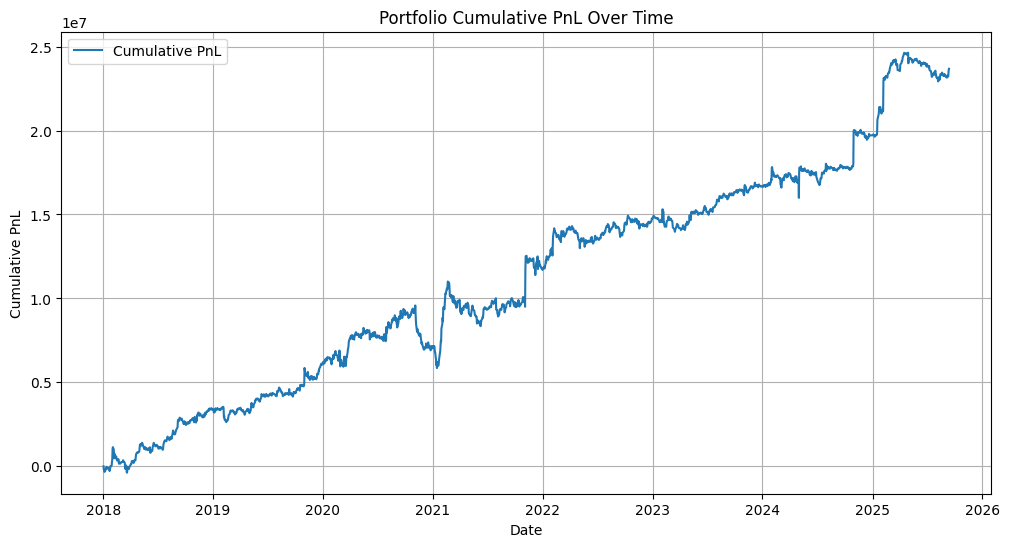

In [10]:
cum_pnl = trading_results["portfolio_cum_pnl"]

plt.figure(figsize=(12, 6))
plt.plot(cum_pnl, label="Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.title("Portfolio Cumulative PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
benchmark = "SPY"
backtest = BackTest(
    trading_results=trading_results,
    start_date=start_date,
    end_date=end_date,
    baskets=filtered_baskets,
    initial_capital=initial_capital,
    benchmark=benchmark,
    risk_free_rate=4.05,
    year_convention=252
)

performance_summary = backtest.summary()
print("\n--- Performance Summary ---")
for metric, value in performance_summary.items():
    print(f"{metric}: {value}")

c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed
c:\Users\meghn\Desktop\Cambridge\Projects\OU\utils\price_data_utils.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(batch, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


--- Performance Summary ---
alpha: 7.784752954192087
beta: 2.187502814501155
sharpe_ratio: 0.3523032553222302
sortino_ratio: 1.7447195554258506
drawdown: -3.5041621703442383
win_rate: 0.516028955532575
